In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from perlin_noise import PerlinNoise
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
# map generation and observation sampling functions from map_generation

def generate_map(size=1000):
    oct1 = random.randint(1,4)
    oct2 = random.randint(3,6)
    oct3 = random.randint(5,8)
    oct4 = random.randint(7,10)
    noise1 = PerlinNoise(octaves=oct1)
    noise2 = PerlinNoise(octaves=oct2)
    noise3 = PerlinNoise(octaves=oct3)
    noise4 = PerlinNoise(octaves=oct4)
    xpix, ypix = size, size

    pic = []
    for i in range(xpix):
        row = []
        for j in range(ypix):
            noise_val = noise1([i/xpix, j/ypix])
            noise_val += 0.5 * noise2([i/xpix, j/ypix])
            noise_val += 0.25 * noise3([i/xpix, j/ypix])
            noise_val += 0.125 * noise4([i/xpix, j/ypix])

            row.append(noise_val)
        pic.append(row)

    pic = np.array(pic)
    # min-max normalize so that all values are between 0 and 1
    pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
    
    return pic

def get_noisy_observations(truemap, n, obs_size=25):
    obs_len = truemap.shape[0]//obs_size
    sample_locs = np.random.choice(obs_len**2, size=(n,), replace=False)
    observations = []
    noisy_observations = []
    # locations will have the bounds of each observation
    locations = []
    for loc in sample_locs:
        row = loc // obs_len
        col = loc % obs_len
        observation = np.array(truemap)[row*obs_size:(row+1)*obs_size, col*obs_size:(col+1)*obs_size]
        noise = np.random.uniform(high=np.mean(observation)/20, size=observation.shape)
        noisy_observation = observation + noise
        noisy_observation = (noisy_observation - np.min(noisy_observation))/(np.max(noisy_observation)-np.min(noisy_observation))
        observations.append(observation)
        noisy_observations.append(noisy_observation)
        locations.append((row*obs_size,(row+1)*obs_size,col*obs_size,(col+1)*obs_size))
    
    return observations, noisy_observations, locations

In [20]:
# generate map
SIZE = 200
OBS_SIZE = 20

newmap = generate_map(size=SIZE)

In [96]:
# get noisy samples from true map. these are our traning data
SAMPLES = 7

true_obs, noisy_obs, loc_obs = get_noisy_observations(newmap, SAMPLES, obs_size=OBS_SIZE)

train_X = []
train_y = []
only_obs_map = np.zeros((SIZE, SIZE))
only_noisy_obs_map = np.zeros((SIZE, SIZE))
# turn observations into train_X and train_y
for i, noisy_ob in enumerate(noisy_obs):
    # true location of observed function values
    # is offset of observation (top left) plus
    # location within observation
    r_off, _, c_off, _ = loc_obs[i]
    for r in range(noisy_ob.shape[0]):
        for c in range(noisy_ob.shape[1]):
            train_X.append([r_off+r, c_off+c])
            train_y.append(noisy_ob[r][c])
    true_ob = true_obs[i]
    only_obs_map[r_off:r_off+OBS_SIZE, c_off:c_off+OBS_SIZE] = true_ob
    only_noisy_obs_map[r_off:r_off+OBS_SIZE, c_off:c_off+OBS_SIZE] = noisy_ob

train_X = np.array(train_X)
train_y = np.array(train_y)

# get locations for overall map space as well
X, Y = np.mgrid[0:SIZE:1, 0:SIZE:1]
test_X = np.vstack((X.flatten(), Y.flatten())).T

In [97]:
# gaussian process implementation with sklearn
#kernel = C(1.0, (1e-2, 1e2)) + RBF([10,10], (1, 1e3))
kernel = C(1.0, (1e-2, 1e2)) + RBF([3,3], "fixed")
#kernel = RBF([10,10], (10, 1e6))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
gp.fit(train_X, train_y)
y_pred, mse = gp.predict(test_X, return_std=True)

/Users/saaketh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/saaketh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


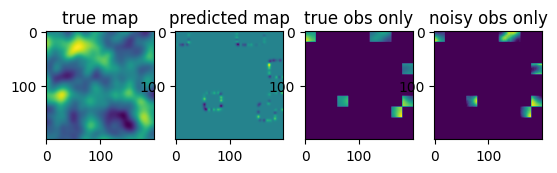

In [98]:
pred_map = y_pred.reshape(newmap.shape)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(newmap)
ax1.set_title("true map")
ax2.imshow(pred_map)
ax2.set_title("predicted map")
ax3.imshow(only_obs_map)
ax3.set_title("true obs only")
ax4.imshow(only_noisy_obs_map)
ax4.set_title("noisy obs only")
plt.show()